In [1]:
import NotebookImport
from Imports import *

importing IPython notebook from Imports

In [2]:
cd Notebooks/

/cellar/users/agross/TCGA_Code/DX/Notebooks


In [3]:
from Preprocessing.ClinicalDataFilters import *

importing IPython notebook from Preprocessing/ClinicalDataFilters

importing IPython notebook from Preprocessing/ClinicalData

PCPG
UCS
TGCT
CHOL
THYM
MESO
FPPP


/cellar/users/agross/anaconda2/lib/python2.7/site-packages/Processing/ProcessClinicalDataPortal.py:37: SettingWithCopyWarning: A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index,col_indexer] = value instead
  f['vitalstatus'] = f['daystodeath'].isnull()


In [4]:
proliferation = pd.read_csv('/cellar/users/agross/TCGA_Code/DX/rna_signature.csv',
                            header=None, index_col=[0,1], squeeze=True)
proliferation = proliferation[:,1]
proliferation.name = 'proliferation'

In [5]:
proliferation

0
TCGA-02-0047    0.10
TCGA-02-0055    0.33
TCGA-02-2483    0.34
TCGA-02-2485    0.23
TCGA-02-2486    0.22
TCGA-04-1348    0.57
TCGA-04-1357    0.45
TCGA-04-1362    0.40
TCGA-04-1364    0.48
TCGA-04-1365    0.57
TCGA-04-1514    0.33
TCGA-04-1519    0.36
TCGA-05-4244    0.51
TCGA-05-4249    0.43
TCGA-05-4250    0.58
...
TCGA-ZN-A9VW    0.47
TCGA-ZP-A9CV    0.28
TCGA-ZP-A9CY    0.18
TCGA-ZP-A9CZ    0.40
TCGA-ZP-A9D0    0.21
TCGA-ZP-A9D1    0.27
TCGA-ZP-A9D2    0.43
TCGA-ZP-A9D4    0.24
TCGA-ZS-A9CD    0.31
TCGA-ZS-A9CE    0.27
TCGA-ZS-A9CF    0.23
TCGA-ZS-A9CG    0.18
TCGA-ZT-A8OM    0.34
TCGA-ZU-A8S4    0.56
TCGA-ZX-AA5X    0.55
Name: proliferation, Length: 9051, dtype: float64

In [6]:
v = rna_df.ix['ABCB1'][:,'01']

In [7]:
cancer = run.load_cancer('KIRC')
rna = cancer.load_data('mRNASeq')

In [135]:
%%time
rr = {}
for i,v in rna.pathways.iterrows():
    rr[i] = get_cox_ph_ms(surv_5y, v, [age > 75], 
                          interactions=False)

CPU times: user 1min 35s, sys: 76.3 ms, total: 1min 35s
Wall time: 1min 35s


In [137]:
pd.concat(rr,1).T.sort('LR').head(3)

,LR,feature_p,fmla,hazzard
KEGG_FATTY_ACID_METABOLISM,2.76e-12,2.69e-12,"Surv(days, event) ~ feature + age\n",0.561
KEGG_BUTANOATE_METABOLISM,1.14e-10,2.84e-11,"Surv(days, event) ~ feature + age\n",0.592
REACTOME_E2F_ENABLED_INHIBITION_OF_PRE_REPLICATION_COMPLEX_FORMATION,3.17e-10,5.7e-12,"Surv(days, event) ~ feature + age\n",1.63


In [140]:
U, S, vH = frame_svd(rna.df.xs('01',1,1))
spearman_pandas(vH[1], proliferation)

In [8]:
%%time
rr = {}
for i,v in rna.pathways.iterrows():
    rr[i] = get_cox_ph_ms(surv_5y, v, [proliferation, age > 75], 
                          interactions=False)

CPU times: user 2min 32s, sys: 106 ms, total: 2min 32s
Wall time: 2min 32s


In [9]:
pd.concat(rr,1).T.sort('LR').head()

,LR,feature_p,fmla,hazzard
KEGG_FATTY_ACID_METABOLISM,0.000148,0.000151,"Surv(days, event) ~ feature + proliferation + ...",0.704
BIOCARTA_FEEDER_PATHWAY,0.000808,0.00046,"Surv(days, event) ~ feature + proliferation + ...",0.755
KEGG_OTHER_GLYCAN_DEGRADATION,0.00128,0.00139,"Surv(days, event) ~ feature + proliferation + ...",0.746
BIOCARTA_NEUROTRANSMITTERS_PATHWAY,0.00164,0.00188,"Surv(days, event) ~ feature + proliferation + ...",1.31
KEGG_BUTANOATE_METABOLISM,0.00228,0.00211,"Surv(days, event) ~ feature + proliferation + ...",0.76


In [10]:
rr2 = {}
for g in run.gene_sets['KEGG_OTHER_GLYCAN_DEGRADATION']:
    if g not in rna.df.index:
        continue
    rr2[g] = get_cox_ph_ms(surv_5y, rna.df.ix[g][:,'01'], [proliferation, age > 75], 
                          interactions=False)
rr2 = pd.concat(rr2,1).T.sort('LR')

In [11]:
rr2.head()

,LR,feature_p,fmla,hazzard
ENGASE,2.83e-05,2.73e-05,"Surv(days, event) ~ feature + proliferation + ...",1.46
FUCA1,4.72e-05,6e-05,"Surv(days, event) ~ feature + proliferation + ...",0.593
GBA,0.00959,0.00976,"Surv(days, event) ~ feature + proliferation + ...",0.632
MAN2C1,0.0139,0.0133,"Surv(days, event) ~ feature + proliferation + ...",1.38
AGA,0.0298,0.0317,"Surv(days, event) ~ feature + proliferation + ...",0.655


In [12]:
idx = rna.df.columns.levels[0]
cox(proliferation.ix[idx], surv_5y)

hazard       exp(coef)     3.16e+02
             exp(-coef)    3.17e-03
             lower .95     7.75e+01
             upper .95     1.29e+03
LR           stat          6.38e+01
             df            1.00e+00
             p             1.33e-15
concordance  stat          6.90e-01
             se            2.51e-02
dtype: float64

In [13]:
v = rna.df.ix[['FUCA1']].mean()[:,'01']
cox(v, surv_5y)

hazard       exp(coef)     5.05e-01
             exp(-coef)    1.98e+00
             lower .95     3.80e-01
             upper .95     6.70e-01
LR           stat          2.36e+01
             df            1.00e+00
             p             1.20e-06
concordance  stat          6.26e-01
             se            2.51e-02
dtype: float64

In [17]:
v = rna.df.ix['FUCA1'][:,'01']
v2 = rna.df.ix['ENGASE'][:,'01']
v = extract_pc(rna.df.ix[['FUCA1','ENGASE']].xs('01',1,1))['pat_vec']
print get_cox_ph(surv_5y, v, [proliferation], 
                 interactions=True)

Call:
(function (formula, data, weights, subset, na.action, init, control, 
    ties = c("efron", "breslow", "exact"), singular.ok = TRUE, 
    robust = FALSE, model = FALSE, x = FALSE, y = TRUE, tt, method = ties, 
    ...) 
{
    ties <- match.arg(ties)
    Call <- match.call()
    indx <- match(c("formula", "data", "weights", "subset", "na.action"), 
        names(Call), nomatch = 0)
    if (indx[1] == 0) 
        stop("A formula argument is required")
    temp <- Call[c(1, indx)]
    temp[[1]] <- as.name("model.frame")
    special <- c("strata", "cluster", "tt")
    temp$formula <- if (missing(data)) 
        terms(formula, special)
    else terms(formula, special, data = data)
    if (!is.null(attr(temp$formula, "specials")$tt)) {
        coxenv <- new.env(parent = environment(formula))
        assign("tt", function(x) x, env = coxenv)
        environment(temp$formula) <- coxenv
    }
    mf <- eval(temp, parent.frame())
    if (nrow(mf) == 0) 
        stop("No (non-missing) obser

In [52]:
mut = cancer.load_data('Mutation')
mut.uncompress()

In [55]:
rr = screen_feature(v.dropna(), rev_kruskal, mut.features, align=False)

In [133]:
p = proliferation.dropna()
p = (pd.DataFrame({q: p > p.quantile(q) for q in np.arange(.2,1.01, .2)})
                 .apply(pd.Series.idxmin,1))

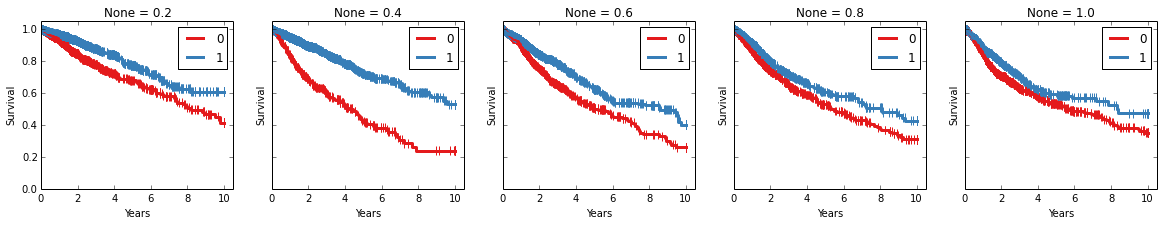

In [134]:
v = rna_df.ix['FUCA1'][:,'01']
draw_survival_curves(to_quants(v, q=.5),
                     surv_10y, p, legend=True)

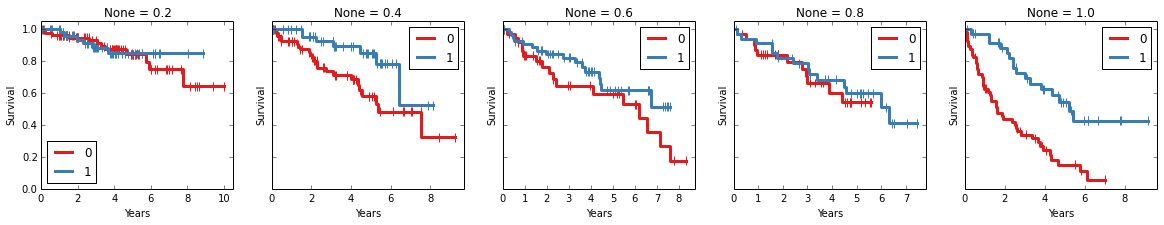

In [132]:
v = rna_df.ix['FUCA1'][:,'01'].ix[ti(codes.str.startswith('KIRC'))]
draw_survival_curves(to_quants(v, q=.5),
                     surv_10y, p, legend=True)

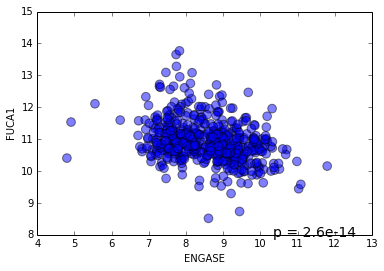

In [58]:
series_scatter(rna.df.ix['ENGASE'][:,'01'], rna.df.ix['FUCA1'][:,'01'])

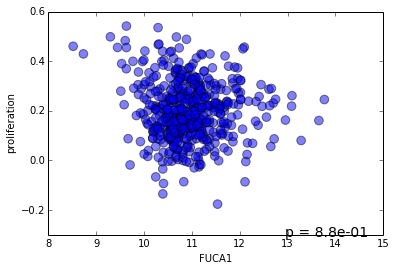

In [53]:
series_scatter(rna.df.ix['FUCA1'][:,'01'], proliferation)

In [55]:
r = {}
for c in codes.unique():
    try:
        r[c] = get_cox_ph_ms(surv_5y, rna_df.ix['FUCA1'][:,'01'].ix[ti(codes==c)], 
                            [proliferation], 
                            interactions=False)
    except:
        print c

STAD
ESCA
LAML


In [56]:
pd.concat(r, 1).T.sort('LR').head()

,LR,feature_p,fmla,hazzard
ACC,1.59e-05,9.2e-06,"Surv(days, event) ~ feature + proliferation\n",0.414
KIRC,5.44e-05,6.76e-05,"Surv(days, event) ~ feature + proliferation\n",0.599
LGG,0.00168,0.00157,"Surv(days, event) ~ feature + proliferation\n",1.69
BLCA,0.00565,0.00356,"Surv(days, event) ~ feature\n",0.791
SARC,0.00856,0.00948,"Surv(days, event) ~ feature + proliferation\n",0.756


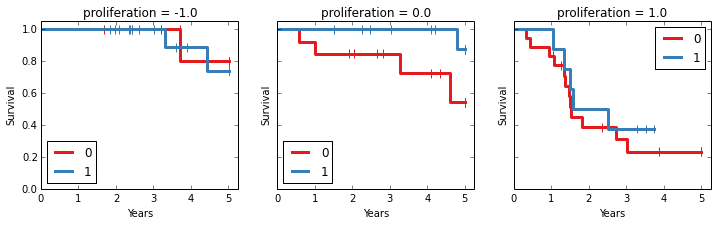

In [77]:
draw_survival_curves(to_quants(rna_df.ix['FUCA1'][:,'01'].ix[ti(codes=='ACC')].dropna(), 
                               q=.5),
                     surv_5y, to_quants(proliferation.ix[ti(codes=='ACC')].dropna(), 
                                        q=.33), legend=True)

In [59]:
r = {}
for c in codes.unique():
    try:
        r[c] = get_cox_ph_ms(surv_5y, rna_df.ix['ENGASE'][:,'01'].ix[ti(codes==c)], 
                            [proliferation], 
                            interactions=False)
    except:
        print c

STAD
ESCA
LAML


In [36]:
pd.concat(r, 1).T.sort('LR').head()

,LR,feature_p,fmla,hazzard
CESC,0.000992,0.000567,"Surv(days, event) ~ feature + proliferation\n",0.812
UCEC,0.00197,0.00214,"Surv(days, event) ~ feature + proliferation\n",0.823
LIHC,0.00797,0.00869,"Surv(days, event) ~ feature + proliferation\n",0.855
PAAD,0.013,0.0132,"Surv(days, event) ~ feature + proliferation\n",1.22
HNSC,0.0152,0.0147,"Surv(days, event) ~ feature + proliferation\n",0.903
